# Plot results for Comparing Preprocessing Pipeline

## Runs analysis using the 5 minute clips used for the DOD grant and the new preprocessing pipeline which enabled use of the entire recording

In [65]:
import numpy as np
import scipy
import scipy.io
import pandas as pd
from pathlib import Path
import os
import collections
from natsort import natsorted
import json
import pickle

from mne_bids import BIDSPath, get_entities_from_fname, get_entity_vals

from sklearn.metrics import auc

import pingouin as pg
from mlxtend.evaluate import mcnemar_table, mcnemar
import dabest

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

### Define some plotting 

In [66]:
# Set font sizes
SMALL_SIZE = 8 * 2
MEDIUM_SIZE = 10 * 2
BIGGER_SIZE = 12 * 2

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rc("font", **{"family": "sans-serif", "sans-serif": ["Arial"]})

In [67]:
def load_participant_df(root, subject):
    """Load participants.tsv file as a dataframe for a specific subject.
    
    Note: subject ID needs to be in format ``sub-<subject>``.
    """
    df = pd.read_csv(os.path.join(root, 'participants.tsv', sep='\t'))
    
    if not subject.startswith('sub-'):
        subject = f'sub-{subject}'
    subj_row = df[df['participant_id'] == subject]
    return subj_row

In [68]:
fullroot = Path("D:/OneDriveParent/OneDrive - Johns Hopkins/Shared Documents/bids")
clippedroot = Path("D:/OneDriveParent/OneDrive - Johns Hopkins/Shared Documents/40Hz-30")

In [69]:
full_deriv_root = fullroot / "derivatives"
clipped_deriv_root = clippedroot / "derivatives"

reference = "monopolar"
deriv_chain = Path("sourcesink") / reference / "remove_artifact_wins"
full_deriv_path = full_deriv_root / deriv_chain
clipped_deriv_path = clipped_deriv_root / deriv_chain

In [70]:
full_figure_dir = full_deriv_root / "figures"
clipped_figure_dir = clipped_deriv_root / "figures"

In [71]:
# here name the experiment something that is uniquely identifiable
# THIS STR WILL BE USED TO PREFIX/SUFFIX ALL FIGURES DOWNSTREAM
full_exp_name = "ssdist"
clipped_exp_name = "ssdistold"

In [72]:
n_splits = 1

clf_name = "logreg"
n_features = 5
n_estimators = (2000,)
max_features = n_features

In [73]:
full_fname = (
    full_deriv_root
    / f"cv{n_splits}_{clf_name}_mtry{max_features}_exp_{full_exp_name}_meandiff.json"
)
clipped_fname = (
    clipped_deriv_root
    / f"cv{n_splits}_{clf_name}_mtry{max_features}_exp_{clipped_exp_name}_meandiff.json"
)

In [74]:
with open(full_fname.with_suffix(".json"), "r") as fp:
    full_scores = json.load(fp)
with open(clipped_fname.with_suffix(".json"), "r") as fp:
    clipped_scores = json.load(fp)

## Run plotting for the full dataset

In [75]:
# either train or test set
which_set = "train"

# construct mean/std ROC curves
tprs = []
aucs = full_scores[f"{which_set}_roc_auc"]
mean_fpr = np.linspace(0, 1, 100)

for idx in range(n_splits):
    fpr = full_scores[f"{which_set}_fpr"][idx]
    tpr = full_scores[f"{which_set}_tpr"][idx]

    # interpolate the tpr
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

In [76]:
# create a dataframe from the statistics
temp_scores = full_scores.copy()
keys = list(temp_scores.keys())
for key in keys:
    if any(
        [
            chars in key
            for chars in [
                "fpr",
                "tpr",
                "fnr",
                "tnr",
                "threshold",
                "fraction_pos",
                "mean_pred_value",
                "subjects",
                "y_pred_proba",
                "importances",
                "train",
            ]
        ]
    ):
        temp_scores.pop(key)
score_df = pd.DataFrame(temp_scores)

display(score_df.head())

,fit_time,score_time,test_roc_auc,test_accuracy,test_balanced_accuracy,test_average_precision,test_precision,test_neg_brier_score,test_recall,test_f1,test_specificity
0,0.350082,0.004,0.583333,0.428571,0.458333,0.645833,0.5,-0.251367,0.25,0.333333,0.666667


In [77]:
score_df.describe().to_csv(full_figure_dir / f"{clf_name}_sourcesink_metrics_meansstd.csv")

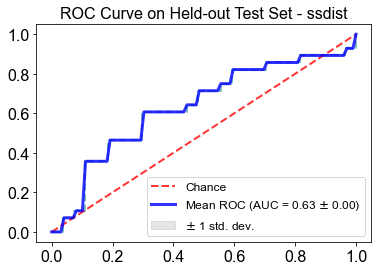

In [78]:
fig, ax = plt.subplots()

for idx in range(n_splits):
    fpr = full_scores[f"{which_set}_fpr"][idx]
    tpr = full_scores[f"{which_set}_tpr"][idx]

    ax.plot(fpr, tpr, color="teal", lw=2, alpha=0.5, ls="--")

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=3,
    alpha=0.8,
)


ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"ROC Curve on Held-out Test Set - {full_exp_name}",
)
ax.legend(loc="lower right", fontsize=12)

# And save it to PDF
fig.savefig(full_figure_dir / f"roc_curve_{full_exp_name}.pdf", bbox_inches="tight")

In [79]:
source_root = fullroot / "sourcedata"
meta_fpath = source_root / "JHU_scalp_clinical_datasheet_raw_local.xlsx"
meta_df = pd.read_excel(meta_fpath)
display(meta_df.head(2))

,patient_id,hospital_id,number_datasets,CLINICAL_CENTER,modality,montage,sfreq,GROUP,outcome,ETHNICITY,...,HAND,GENDER,bad_contacts,EPILEPSY_TYPE,imaging_outcome_notes,Date of Recording,Notes,include,Reason,best_window
0,101,1,1,jhh,scalp,standard 10-20,200,1,1,NaN,...,NaN,NaN,"Fz, Cz, E, X1-7, SpO2, EtCO2, DC03, DC04, DC05...",focal,NaN,NaN,"Lots of eye artifact. Pz looks more normal, bu...",Y,"Good after 100 s, remove Pz",100-400
1,201,2,1,jhh,scalp,standard 10-20,200,2,2,NaN,...,NaN,NaN,"E, X1-7, SpO2, EtCO2, DC03, DC04, DC05, DC06, ...",NaN,NaN,NaN,SHW',Y,Riddled with artifact,600-900


In [80]:
# TODO: modify to fit the participants framework
y_probas = []
subj_list = []
outcomes = []
centers = []
folds = []

for idx in range(n_splits):
    y_pred_proba = full_scores[f"{which_set}_y_pred_proba"][idx]
    cv_subjects = full_scores[f"{which_set}_subjects"][idx]
    for subject in cv_subjects:
        subject_id = subject.replace("jhh", "")
        sub_row = meta_df[meta_df["patient_id"] == int(subject_id)]
        outcome = sub_row["outcome"].values[0]
        outcomes.append(outcome)

        center = sub_row["CLINICAL_CENTER"].values[0]
        centers.append(center)

    y_probas.extend(y_pred_proba)
    subj_list.extend(cv_subjects)
    folds.extend([idx] * len(cv_subjects))

In [81]:
proba_df = pd.DataFrame(
    (y_probas, subj_list, outcomes, centers, folds)
).T
proba_df.columns = ["y_proba", "subject", "outcome", "center", "fold"]


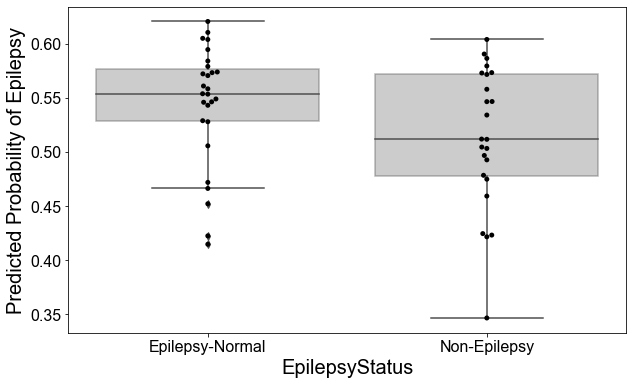

In [97]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(
    x="outcome",
    y="y_proba",
    color="gray",
    data=proba_df,
    ax=ax,
    boxprops=dict(alpha=0.4),
)
sns.swarmplot(x="outcome", y="y_proba", color="black", data=proba_df, ax=ax)

ax.set(
    ylabel="Predicted Probability of Epilepsy",
    xlabel="EpilepsyStatus",
    xticks=[0,1],
    xticklabels=['Epilepsy-Normal', 'Non-Epilepsy']
)
fig.savefig(full_figure_dir / f"{full_exp_name}_y_pred_proba_epilepsy_prediction.pdf", bbox_inches="tight")

## Run plotting for the old "clipped" dataset

In [88]:
# either train or test set
which_set = "train"

# construct mean/std ROC curves
tprs = []
aucs = clipped_scores[f"{which_set}_roc_auc"]
mean_fpr = np.linspace(0, 1, 100)

for idx in range(n_splits):
    fpr = clipped_scores[f"{which_set}_fpr"][idx]
    tpr = clipped_scores[f"{which_set}_tpr"][idx]

    # interpolate the tpr
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

In [89]:
# create a dataframe from the statistics
temp_scores = clipped_scores.copy()
keys = list(temp_scores.keys())
for key in keys:
    if any(
        [
            chars in key
            for chars in [
                "fpr",
                "tpr",
                "fnr",
                "tnr",
                "threshold",
                "fraction_pos",
                "mean_pred_value",
                "subjects",
                "y_pred_proba",
                "importances",
                "train",
            ]
        ]
    ):
        temp_scores.pop(key)
score_df = pd.DataFrame(temp_scores)

display(score_df.head())

,fit_time,score_time,test_roc_auc,test_accuracy,test_balanced_accuracy,test_average_precision,test_precision,test_neg_brier_score,test_recall,test_f1,test_specificity
0,1.104623,0.004001,0.666667,0.666667,0.666667,0.638889,0.6,-0.240199,1.0,0.75,0.333333


In [90]:
score_df.describe().to_csv(clipped_figure_dir / f"{clf_name}_sourcesink_metrics_meansstd.csv")

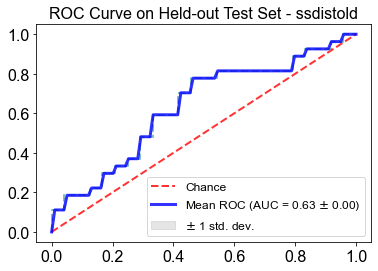

In [91]:
fig, ax = plt.subplots()

for idx in range(n_splits):
    fpr = clipped_scores[f"{which_set}_fpr"][idx]
    tpr = clipped_scores[f"{which_set}_tpr"][idx]

    ax.plot(fpr, tpr, color="teal", lw=2, alpha=0.5, ls="--")

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=3,
    alpha=0.8,
)


ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"ROC Curve on Held-out Test Set - {clipped_exp_name}",
)
ax.legend(loc="lower right", fontsize=12)

# And save it to PDF
fig.savefig(clipped_figure_dir / f"roc_curve_{clipped_exp_name}.pdf", bbox_inches="tight")

In [92]:
# TODO: modify to fit the participants framework
y_probas = []
subj_list = []
outcomes = []
centers = []
folds = []

for idx in range(n_splits):
    y_pred_proba = clipped_scores[f"{which_set}_y_pred_proba"][idx]
    cv_subjects = clipped_scores[f"{which_set}_subjects"][idx]
    for subject in cv_subjects:
        subject_id = subject.replace("jhh", "")
        sub_row = meta_df[meta_df["patient_id"] == int(subject_id)]
        outcome = sub_row["outcome"].values[0]
        outcomes.append(outcome)

        center = sub_row["CLINICAL_CENTER"].values[0]
        centers.append(center)

    y_probas.extend(y_pred_proba)
    subj_list.extend(cv_subjects)
    folds.extend([idx] * len(cv_subjects))

In [93]:
proba_df = pd.DataFrame(
    (y_probas, subj_list, outcomes, centers, folds)
).T
proba_df.columns = ["y_proba", "subject", "outcome", "center", "fold"]

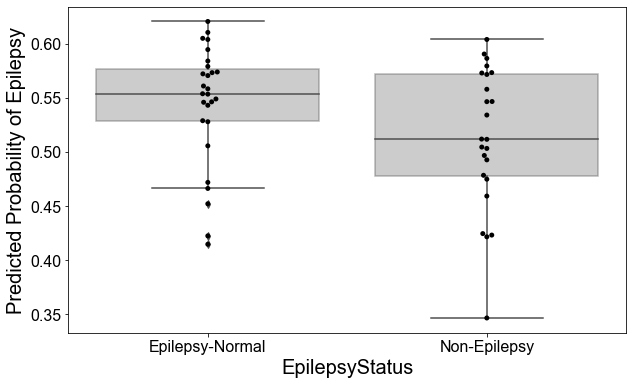

In [96]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(
    x="outcome",
    y="y_proba",
    color="gray",
    data=proba_df,
    ax=ax,
    boxprops=dict(alpha=0.4),
)
sns.swarmplot(x="outcome", y="y_proba", color="black", data=proba_df, ax=ax)

ax.set(
    ylabel="Predicted Probability of Epilepsy",
    xlabel="EpilepsyStatus",
    xticks=[0,1],
    xticklabels=['Epilepsy-Normal', 'Non-Epilepsy']
)
fig.savefig(clipped_figure_dir / f"{clipped_exp_name}_y_pred_proba_epilepsy_prediction.pdf", bbox_inches="tight")